In [132]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from copy import deepcopy
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time
from matplotlib import gridspec
import seaborn as sns
import matplotlib.patches as mpatches

# adaptive-wavelets modules
from eval_biology import load_results, max_transformer, get_tensors, max_fun
from awave.data.biology import get_dataloader, load_pretrained_model
from awave.utils.misc import tuple_to_tensor, get_wavefun
from awave.trim import TrimModel
import awave
from umap import UMAP
from sklearn.decomposition import PCA
import seaborn
import pandas as pd

# evaluation
from eval_biology import load_results, max_transformer
from ex_biology import p

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dirs = [
    "db5_saliency_warmstart_seed=1",
]
dics, results, models = load_results(dirs)

In [3]:
# load data
(train_loader, test_loader) = get_dataloader(p.data_path,
                                             batch_size=p.batch_size,
                                             is_continuous=True)

# cross validation
reg_score = []

for i, wt in enumerate(list(dics[0]['wt'].values())):
    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = max_transformer(wt,
                                               train_loader,
                                               test_loader,
                                               sgn="pos",
                                               m=6)

    clf = LinearRegression()
    scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
    reg_score.append(scores.mean())
reg_score = np.array(reg_score)

# select best wavelet
idx1, idx2 = list(dics[0]['wt'].keys())[np.argmax(reg_score).flatten()[0]]
wt = dics[0]['wt'][(idx1, idx2)]

# original wavelet transform
wt_o = awave.DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0)

In [4]:
# test data and wavelet coeffs
X_test = test_loader.dataset.tensors[0]
y_test = test_loader.dataset.tensors[1]
y_test = y_test.cpu().numpy().squeeze()
X1 = wt(X_test)
X2 = wt_o(X_test)

# pca
pca = PCA(n_components=6)

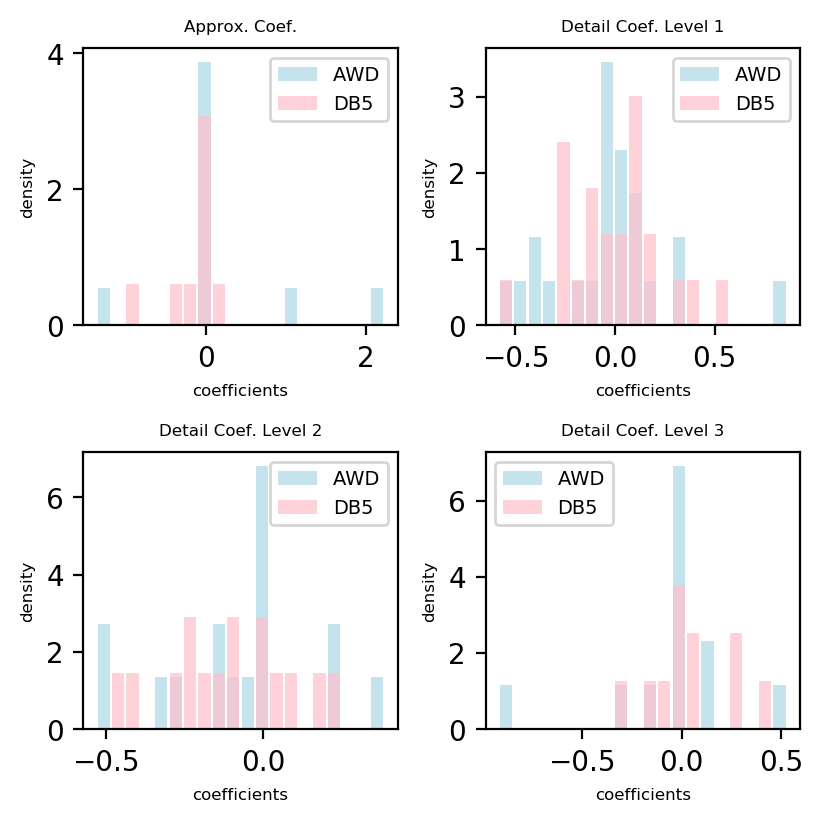

In [167]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['red', 'lightblue']
n = 1005
np.random.seed(20)
random_index = np.random.randint(0, n)
coefs1 = [x[random_index].detach().cpu().numpy().squeeze() for x in X1]
coefs2 = [x[random_index].detach().cpu().numpy().squeeze() for x in X2]

# embedding1 vs embedding2
f_ax1 = fig.add_subplot(spec[0, 0])

_, bins, _ = plt.hist(coefs1[0], bins=20, color='lightblue', alpha=0.7, rwidth=0.85, density=True, label='AWD')
_ = plt.hist(coefs2[0], bins=bins, color='pink', alpha=0.7, rwidth=0.85, normed=True, label='DB5')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(prop={'size': 7})
plt.title("Approx. Coef.", fontsize=6)
plt.xlabel('coefficients', fontsize=6)
plt.ylabel('density', fontsize=6)

# embedding1 vs embedding2
f_ax2 = fig.add_subplot(spec[0, 1])

_, bins, _ = plt.hist(coefs1[1], bins=20, color='lightblue', alpha=0.7, rwidth=0.85, density=True, label='AWD')
_ = plt.hist(coefs2[1], bins=bins, color='pink', alpha=0.7, rwidth=0.85, normed=True, label='DB5')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(prop={'size': 7})
plt.title("Detail Coef. Level 1", fontsize=6)
plt.xlabel('coefficients', fontsize=6)
plt.ylabel('density', fontsize=6)

# embedding1 vs embedding2
f_ax3 = fig.add_subplot(spec[1, 0])

_, bins, _ = plt.hist(coefs1[2], bins=20, color='lightblue', alpha=0.7, rwidth=0.85, density=True, label='AWD')
_ = plt.hist(coefs2[2], bins=bins, color='pink', alpha=0.7, rwidth=0.85, normed=True, label='DB5')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(prop={'size': 7})
plt.title("Detail Coef. Level 2", fontsize=6)
plt.xlabel('coefficients', fontsize=6)
plt.ylabel('density', fontsize=6)

# embedding1 vs embedding2
f_ax4 = fig.add_subplot(spec[1, 1])

_, bins, _ = plt.hist(coefs1[3], bins=20, color='lightblue', alpha=0.7, rwidth=0.85, density=True, label='AWD')
_ = plt.hist(coefs2[3], bins=bins, color='pink', alpha=0.7, rwidth=0.85, normed=True, label='DB5')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(prop={'size': 7})
plt.title("Detail Coef. Level 3", fontsize=6)
plt.xlabel('coefficients', fontsize=6)
plt.ylabel('density', fontsize=6)

plt.show()

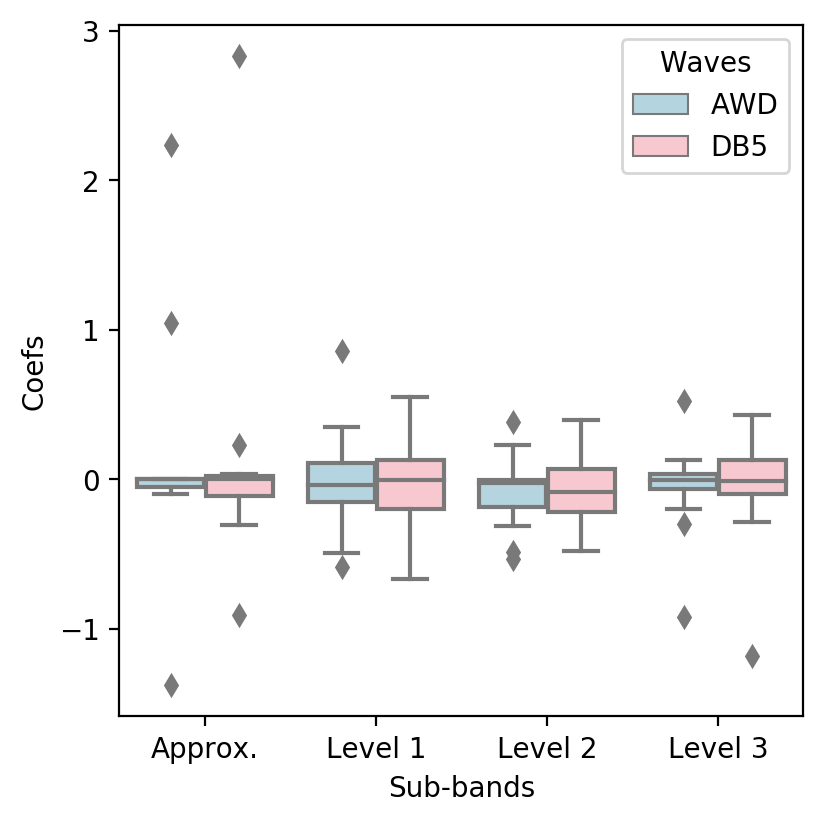

In [168]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

f_ax1 = fig.add_subplot(spec[0, 0])

all_coefs = coefs1[:4] + coefs2[:4]
all_coefs = list(np.concatenate(all_coefs))
labels = ["Approx."]*10 + ["Level 1"]*24 + ["Level 2"]*16 + ["Level 3"]*12
labels = labels + labels
waves = ["AWD"]*62 + ["DB5"]*62

df = pd.DataFrame(list(zip(all_coefs, labels, waves)), columns =['Coefs', 'Sub-bands', 'Waves'])
ax = sns.boxplot(x="Sub-bands", y="Coefs", hue="Waves", data=df, palette=['lightblue', 'pink'])
plt.show()